# 1. Veri Setlerinin Yüklenmesi ve İlk Bakış
Bu aşamada, Google Play Store uygulama verileri (`googleplaystore.csv`) ve kullanıcı yorumları (`googleplaystore_user_reviews.csv`) yüklenmektedir. Veri setlerinin genel yapısını anlamak için ilk 5 satır incelenerek verinin doğru yüklendiği teyit edilir.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


In [2]:
apps_df = pd.read_csv("googleplaystore.csv")

reviews_df = pd.read_csv(
    "googleplaystore_user_reviews.csv",
    encoding="latin1",
    on_bad_lines="skip"
)

print("Apps Shape:", apps_df.shape)
print("Reviews Shape:", reviews_df.shape)


Apps Shape: (10841, 13)
Reviews Shape: (64295, 5)


In [3]:
import pandas as pd

df = pd.read_csv("googleplaystore.csv")

reviews_df = pd.read_csv(
    "googleplaystore_user_reviews.csv",
    encoding="latin1",
    on_bad_lines="skip"
)

print("Apps Shape:", df.shape)
print("Reviews Shape:", reviews_df.shape)

print("\nApps Preview:")
print(df.head().to_string(index=False))

print("\nReviews Preview:")
print(reviews_df.head().to_string(index=False))


Apps Shape: (10841, 13)
Reviews Shape: (64295, 5)

Apps Preview:
                                               App       Category  Rating Reviews Size    Installs Type Price Content Rating                    Genres     Last Updated        Current Ver  Android Ver
    Photo Editor & Candy Camera & Grid & ScrapBook ART_AND_DESIGN     4.1     159  19M     10,000+ Free     0       Everyone              Art & Design  January 7, 2018              1.0.0 4.0.3 and up
                               Coloring book moana ART_AND_DESIGN     3.9     967  14M    500,000+ Free     0       Everyone Art & Design;Pretend Play January 15, 2018              2.0.0 4.0.3 and up
U Launcher Lite – FREE Live Cool Themes, Hide Apps ART_AND_DESIGN     4.7   87510 8.7M  5,000,000+ Free     0       Everyone              Art & Design   August 1, 2018              1.2.4 4.0.3 and up
                             Sketch - Draw & Paint ART_AND_DESIGN     4.5  215644  25M 50,000,000+ Free     0           Teen           

In [4]:
print(reviews_df.columns)


Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'],
      dtype='object')


# 2. Veri Entegrasyonu ve İlk Temizleme
Bu adımda analiz ve modelleme için temel hazırlıklar yapılır:
* **Duyarlılık Entegrasyonu:** Kullanıcı yorumlarından elde edilen ortalama duyarlılık (`Avg_Sentiment_Polarity`) ve öznellik (`Avg_Sentiment_Subjectivity`) metrikleri ana tabloya eklenerek özellik sayısı artırılır.
* **Tekilleştirme:** Uygulama isimlerine göre en güncel kayıtlar (Last Updated) tutularak mükerrer veriler temizlenir.
* **Hedef Değişken Oluşturma:** `Rating` değeri 4.0 ve üzeri olan uygulamalar "Başarılı" (1), diğerleri (0) olarak sınıflandırılarak modelin tahmin edeceği hedef belirlenir.

In [5]:
reviews_df = reviews_df.dropna(subset=['Sentiment_Polarity'])

sentiment_agg = reviews_df.groupby('App').agg({
    'Sentiment_Polarity': 'mean',
    'Sentiment_Subjectivity': 'mean'
}).reset_index()

sentiment_agg.columns = [
    'App',
    'Avg_Sentiment_Polarity',
    'Avg_Sentiment_Subjectivity'
]

print("\nSentiment Features Preview:")
print(sentiment_agg.head().to_string(index=False))



Sentiment Features Preview:
                                                                       App  Avg_Sentiment_Polarity  Avg_Sentiment_Subjectivity
                                                     10 Best Foods for You                0.470733                    0.495455
104 æ¾å·¥ä½ - æ¾å·¥ä½ æ¾æå·¥ æ¾å¼è· å±¥æ­·å¥æª¢ å±¥æ­·è¨ºçå®¤                0.392405                    0.545516
                                                                      11st                0.181294                    0.443957
                                                1800 Contacts - Lens Store                0.318145                    0.591098
                                         1LINE â One Line with One Touch                0.196290                    0.557315


In [6]:
df = apps_df.merge(
    sentiment_agg,
    on='App',
    how='left'
)

print("\nMerged Dataset Shape:", df.shape)



Merged Dataset Shape: (10841, 15)


In [7]:

df = df.dropna(subset=['Rating'])

# Reviews
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Installs
df['Installs'] = df['Installs'].astype(str)
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Price
df['Price'] = df['Price'].astype(str)
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Sentiment
df['Avg_Sentiment_Polarity'] = pd.to_numeric(df['Avg_Sentiment_Polarity'], errors='coerce')
df['Avg_Sentiment_Subjectivity'] = pd.to_numeric(df['Avg_Sentiment_Subjectivity'], errors='coerce')


df = df.dropna(subset=[
    'Reviews',
    'Installs',
    'Price',
    'Avg_Sentiment_Polarity',
    'Avg_Sentiment_Subjectivity'
])


### 3. Özellik Seçimi ve Veri Setinin Ayrılması
Bu adımda modelin tahmin edeceği hedef değişken (`Rating`) ve bu tahminde kullanılacak özellikler (`Reviews`, `Installs`, `Price`, Duyarlılık analizi sonuçları) belirlenir.

Ardından, modelin başarısını objektif bir şekilde ölçebilmek için veri seti **Eğitim (%80)** ve **Test (%20)** olmak üzere iki parçaya ayrılır.

In [8]:
features = [
    'Reviews',
    'Installs',
    'Price',
    'Avg_Sentiment_Polarity',
    'Avg_Sentiment_Subjectivity'
]

X = df[features]
y = df['Rating']

print("\nTarget (Rating) Summary:")
print(y.describe())



Target (Rating) Summary:
count    1140.000000
mean        4.296140
std         0.304809
min         2.600000
25%         4.200000
50%         4.300000
75%         4.500000
max         4.900000
Name: Rating, dtype: float64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


### 4. Modelleme (Regresyon Algoritmaları)
Bu çalışmada, uygulama puanlarını tahmin etmek için iki güçlü topluluk (ensemble) öğrenme algoritması kullanılmıştır:
1.  **Random Forest Regressor:** Çok sayıda karar ağacı oluşturarak bunların ortalamasını alan ve aşırı öğrenmeyi (overfitting) engelleyen bir modeldir.
2.  **Extra Trees Regressor:** Random Forest'a benzer ancak ağaç bölümlerini daha rastgele seçerek varyansı düşürmeyi hedefler.

Her iki model de eğitim seti üzerinde eğitilir ve test seti üzerindeki performansları **MAE** (Ortalama Mutlak Hata), **RMSE** (Kök Ortalama Kare Hata) ve **R²** (Açıklayıcılık Katsayısı) metrikleriyle değerlendirilir.

In [10]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest Results ===")
print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²  :", r2_score(y_test, y_pred_rf))



=== Random Forest Results ===
MAE : 0.13685526315789587
RMSE: 0.22674267623910202
R²  : 0.4917206878451772


In [11]:
et = ExtraTreesRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

et.fit(X_train, y_train)

y_pred_et = et.predict(X_test)

print("\n=== Extra Trees Results ===")
print("MAE :", mean_absolute_error(y_test, y_pred_et))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_et)))
print("R²  :", r2_score(y_test, y_pred_et))



=== Extra Trees Results ===
MAE : 0.11150584795322098
RMSE: 0.21774657775670392
R²  : 0.5312529224418178


### 5. Model Performanslarının Karşılaştırılması
Eğitilen iki modelin test sonuçları bir araya getirilerek karşılaştırılır. Hangi modelin hataları daha aza indirdiği ve varyansı daha iyi açıkladığı bu tabloda görülmektedir.

In [12]:
results_ahmed = pd.DataFrame({
    "Model": ["Random Forest", "Extra Trees"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_et)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_et))
    ],
    "R²": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_et)
    ]
})

print("\nAhmed – Regression Model Comparison Table:")
print(results_ahmed.to_string(index=False))



Ahmed – Regression Model Comparison Table:
        Model      MAE     RMSE       R²
Random Forest 0.136855 0.226743 0.491721
  Extra Trees 0.111506 0.217747 0.531253


### 6. Görselleştirme ve Değerlendirme
Son olarak, modelin başarısını ve verinin yapısını anlamak için görselleştirmeler yapılır:
* **Hedef Değişken Dağılımı:** `Rating` puanlarının genel dağılımını gösterir.
* **Gerçek vs Tahmin Grafikleri:** Modellerin tahmin ettiği değerler ile gerçek değerler arasındaki ilişkiyi (saçılım grafiği üzerinde) gösterir. İdeal senaryoda noktaların diyagonal bir çizgi üzerinde toplanması beklenir.

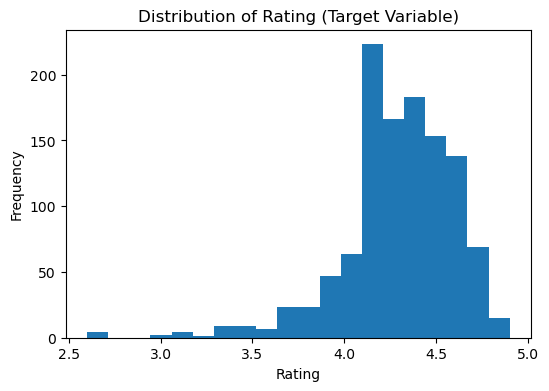

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(y, bins=20)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Rating (Target Variable)")
plt.show()


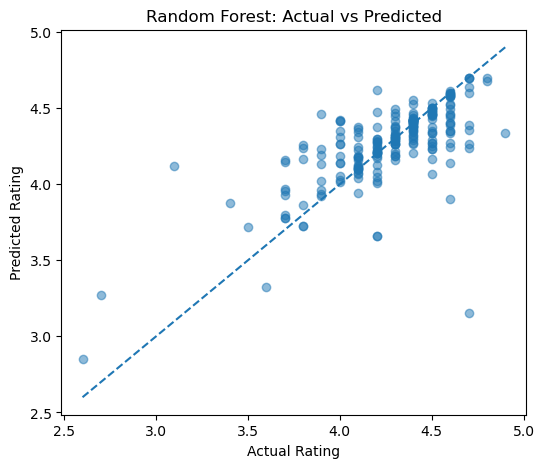

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')

plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


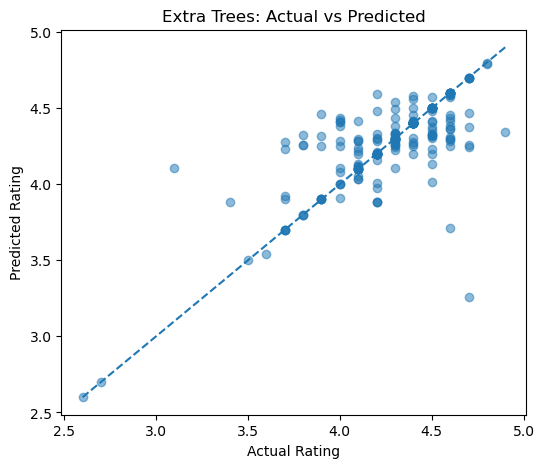

In [15]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_et, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')

plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Extra Trees: Actual vs Predicted")
plt.show()


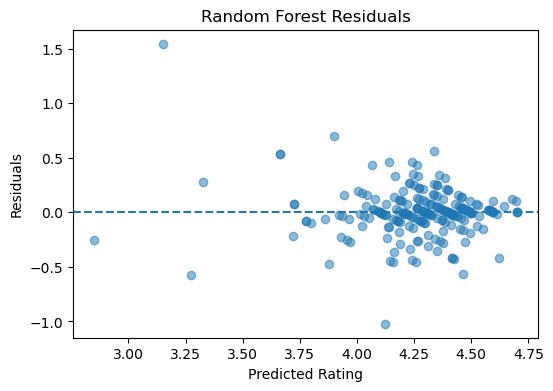

In [16]:
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(6,4))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.5)
plt.axhline(0, linestyle='--')

plt.xlabel("Predicted Rating")
plt.ylabel("Residuals")
plt.title("Random Forest Residuals")
plt.show()


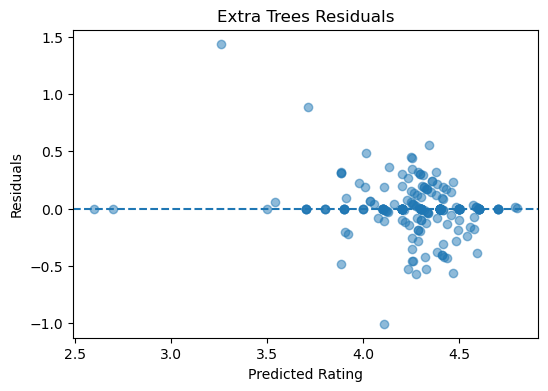

In [17]:
residuals_et = y_test - y_pred_et

plt.figure(figsize=(6,4))
plt.scatter(y_pred_et, residuals_et, alpha=0.5)
plt.axhline(0, linestyle='--')

plt.xlabel("Predicted Rating")
plt.ylabel("Residuals")
plt.title("Extra Trees Residuals")
plt.show()


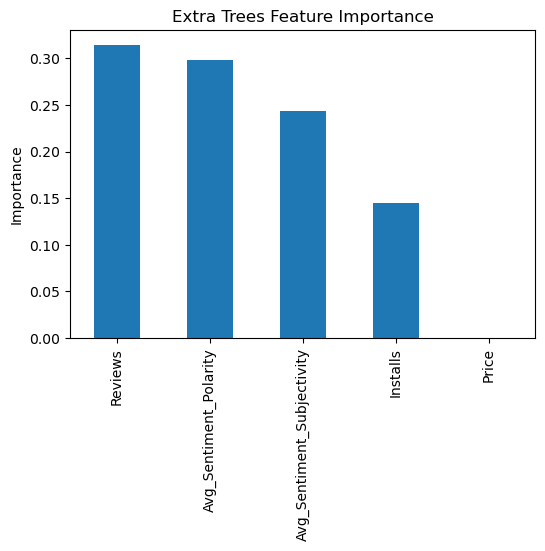

In [18]:
fi_et = pd.Series(et.feature_importances_, index=features)
fi_et = fi_et.sort_values(ascending=False)

plt.figure(figsize=(6,4))
fi_et.plot(kind='bar')
plt.title("Extra Trees Feature Importance")
plt.ylabel("Importance")
plt.show()
